In [4]:
%matplotlib ipympl

_ = """
Need to generate:
 - map_config_path
 - ekf_state_path
 - road_map_path

Environment Types:
 - All independent
 - Spatial Correlations
 - Semantic correlations
 - all mutual exclusion
 - multiple mutual exclusion classes
"""

from experimental.beacon_sim.world_map_config_pb2 import WorldMapConfig
from experimental.beacon_sim.mapped_landmarks_pb2 import MappedLandmarks
from planning.road_map_pb2 import RoadMap
from common.liegroups.se2_python import SE2
import string
import itertools
import matplotlib as mpl

from pathlib import Path

import experimental.beacon_sim.environment_builder as eb
import experimental.beacon_sim.beacon_potential_python as bpp
import planning.probabilistic_road_map_python as prmp
import experimental.beacon_sim.experiment_config_pb2 as experiment_config

from google.protobuf import text_format

import numpy as np

from typing import NamedTuple
import matplotlib.pyplot as plt

In [5]:

def plot_road_map(road_map):
    pts = np.stack(road_map.points())
    plt.plot(pts[:, 0], pts[:, 1], '*')
    for i, pt in enumerate(pts):
        plt.text(*pt, str(i))

    if road_map.has_start_goal():
        for idx, marker in [(road_map.START_IDX, 'rs'), (road_map.GOAL_IDX, 'y*')]:
            pt = road_map.point(idx)
            plt.plot(*pt, marker)
            

    line_segments = []
    for i in range(len(pts)):
        for j in range(i+1, len(pts)):
            if road_map.adj()[i, j] != 0:
                line_segments.append([pts[i, :], pts[j,:]])

    if road_map.has_start_goal():
        for idx in [road_map.START_IDX, road_map.GOAL_IDX]:
            pt = road_map.point(idx)
            neighbors = road_map.neighbors(idx)
            for _, neighbor_pt in neighbors:
                line_segments.append([pt, neighbor_pt])
    

    edges = mpl.collections.LineCollection(line_segments, colors=(0.6, 0.8, 0.6, 1.0))
    ax = plt.gca()
    ax.add_collection(edges)

In [6]:


def generate_independent_landmarks(map_bounds, p_beacon, landmark_density, rng) -> list[eb.DiffuseLandmark | eb.GridLandmark]:
    dist_generator = lambda members: bpp.BeaconPotential.correlated_beacon_potential(1.0, p_beacon, members)
    return [eb.DiffuseLandmark(SE2(), *map_bounds, landmark_density, dist_generator, beacon_ns='b', rng=rng)]
    ...
    
def generate_spatially_correlated_landmarks(
        map_bounds, cluster_density, cluster_size: tuple[int, int], density_within_cluster: float, p_beacon: float, p_no_beacon: float, rng: np.random.Generator
        ) -> list[eb.DiffuseLandmark | eb.GridLandmark]:

    dist_generator = lambda members: None
    cluster_centers = eb.DiffuseLandmark(SE2(), *map_bounds, cluster_density, dist_generator, beacon_ns='b', rng=rng)._pts_in_anchor
    cluster_centers = cluster_centers.T

    out = []
    dist_generator = lambda members: bpp.BeaconPotential.correlated_beacon_potential(1 - p_no_beacon, p_beacon, members)
    for i, pt in enumerate(cluster_centers):
        assert i < len(string.printable)
        ns = string.printable[i]
        out.append(eb.DiffuseLandmark(SE2(pt), *cluster_size, density_within_cluster, dist_generator, beacon_ns=ns, rng=rng))

    total_lms = cluster_centers.shape[0] * out[-1]._pts_in_anchor.shape[1]
    return out

def generate_semantically_correlated_landmarks(map_bounds, num_classes, p_beacon, p_no_beacon, landmark_density, rng) -> list[eb.DiffuseLandmark | eb.GridLandmark]:
    assert num_classes < len(string.printable)
    class_density = landmark_density / num_classes
    out = []
    dist_generator = lambda members: bpp.BeaconPotential.correlated_beacon_potential(1- p_no_beacon, p_beacon, members)
    for i in range(num_classes):
        ns = string.printable[i]
        out.append(eb.DiffuseLandmark(SE2(), *map_bounds, class_density, dist_generator, beacon_ns=ns, rng=rng))
    return out

def generate_mutual_exclusion_landmarks(map_bounds, landmark_density, rng) -> list[eb.DiffuseLandmark | eb.GridLandmark]:
    num_pts = int(map_bounds[0] * map_bounds[1] * landmark_density)
    dist_generator = lambda members: bpp.BeaconPotential.anticorrelated_beacon_potential(members)
    return [eb.DiffuseLandmark(SE2(), *map_bounds, landmark_density, dist_generator, beacon_ns='a', rng=rng)]

def generate_multiple_mutual_exclusion_landmarks(map_bounds, num_classes, landmark_density, rng) -> list[eb.DiffuseLandmark | eb.GridLandmark]:
    assert num_classes < len(string.printable)
    class_density = landmark_density / num_classes
    dist_generator = lambda members: bpp.BeaconPotential.anticorrelated_beacon_potential(members)
    return [eb.DiffuseLandmark(SE2(), *map_bounds, class_density, dist_generator, beacon_ns=string.printable[i], rng=rng) for i in range(num_classes)]



In [7]:
def generate_road_map(map_bounds, grid_dims):

    num_rows = grid_dims[0]
    num_cols = grid_dims[1]

    xs = np.linspace(0, map_bounds[1], num_cols)
    ys = np.linspace(0, map_bounds[0], num_rows)

    
    num_pts = num_rows * num_cols
    pts = []
    adj = np.zeros((num_pts, num_pts))
    for i, (y, x) in enumerate(itertools.product(ys, xs)):
        row_idx = i // num_cols
        col_idx = i % num_cols
        
        pts.append((x,  y))

        # Connect left
        if col_idx > 0:
            neighbor_id = (col_idx - 1) + num_cols * row_idx
            adj[i, neighbor_id] = 1.0
            adj[neighbor_id, i] = 1.0

        # Connect down
        if row_idx > 0:
            neighbor_id = col_idx + num_cols * (row_idx - 1)
            adj[i, neighbor_id] = 1.0
            adj[neighbor_id, i] = 1.0
        

        # Connect diagonally left and down
        if row_idx > 0 and col_idx > 0:
            neighbor_id = (col_idx - 1) + num_cols * (row_idx - 1)
            adj[i, neighbor_id] = 1.0
            adj[neighbor_id, i] = 1.0

        if row_idx > 0 and col_idx < num_cols - 1:
            neighbor_id = (col_idx + 1) + num_cols * (row_idx - 1)
            adj[i, neighbor_id] = 1.0
            adj[neighbor_id, i] = 1.0

    return prmp.RoadMap(pts, adj, None)


(-2.5, 52.5, -1.5, 31.5)

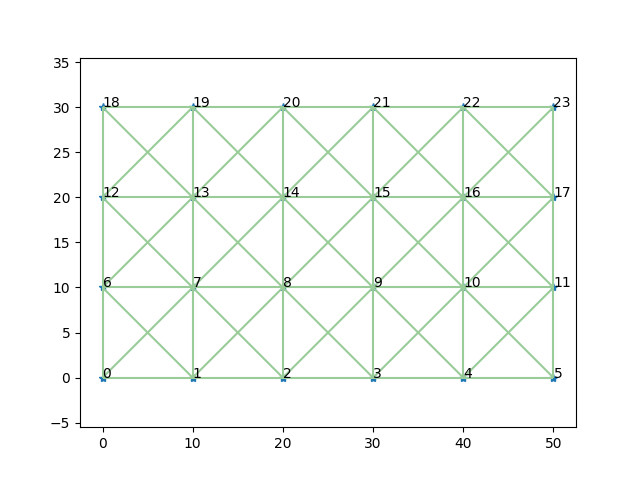

In [8]:
map_bounds = (30, 50)
grid_dims = (4, 6)

road_map = generate_road_map(map_bounds, grid_dims)

plt.figure()
plot_road_map(road_map)
plt.axis('equal')

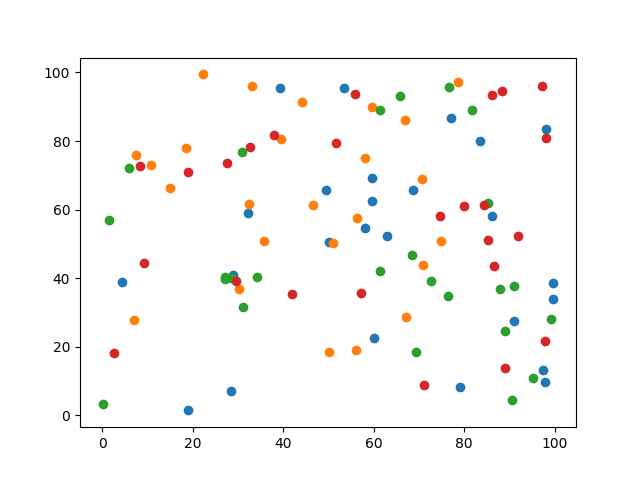

In [9]:

landmark_densities = [1e-3, 1e-2]

map_bounds = (1e2, 1e2)
rng = np.random.default_rng(100)
plt.figure()
landmarks = generate_multiple_mutual_exclusion_landmarks(map_bounds, 4, landmark_density=landmark_densities[1], rng=rng)
eb.draw_landmarks(plt.gca(), landmarks)

In [20]:
def generate_experiment_config(name, timeout_s, rng):
    out = experiment_config.ExperimentConfig()
    out.name = name
    out.map_config_path = "world_map_config.pb"
    out.ekf_state_path = "mapped_landmarks.pb"
    out.road_map_path = "road_map.pb"
    out.evaluation_base_seed = rng.integers(1000000000)
    out.num_eval_trials = 1000
    out.start_goal_seed = rng.integers(1000000000)
    out.start_goal_connection_radius_m = 20.0
    out.num_trials = 10
    out.plan_timeout_s = timeout_s
    out.max_sensor_range_m = 5
    out.uncertainty_metric.CopyFrom(experiment_config.UncertaintySize(
        prob_mass_in_region=experiment_config.ProbMassInRegion(
            position_x_half_width_m=0.5,
            position_y_half_width_m=0.5,
            heading_half_width_rad=6.0,
        )
    ))

    favor_goals = [0.9,0.7,0.5,0.3]
    
    for i, (p_goal) in enumerate(favor_goals):
        out.planner_configs.append(experiment_config.PlannerConfig(
            name = "David Planner FG-"+str(p_goal),
            david_planner_config = experiment_config.DavidPlannerOne(favor_goal = p_goal)
    ))
    
    out.planner_configs.append(experiment_config.PlannerConfig(
        name = "Optimistic BRM",
        optimistic_brm_config = experiment_config.OptimisticBRMPlanner(
            uncertainty_size=experiment_config.UncertaintySize(
                    prob_mass_in_region=experiment_config.ProbMassInRegion(
                        position_x_half_width_m=0.5,
                        position_y_half_width_m=0.5,
                        heading_half_width_rad=6.0,
                    )
                ),
        )
    ))

    for i in [1, 10, 100, 1000]:
        out.planner_configs.append(experiment_config.PlannerConfig(
            name = f"Landmark BRM {i} component",
            landmark_brm_config = experiment_config.LandmarkBRMPlanner(
                max_num_components=i,
                uncertainty_size=experiment_config.UncertaintySize(
                    prob_mass_in_region=experiment_config.ProbMassInRegion(
                        position_x_half_width_m=0.5,
                        position_y_half_width_m=0.5,
                        heading_half_width_rad=6.0,
                    )
                ),
            )
        ))

        out.planner_configs.append(experiment_config.PlannerConfig(
            name = f"Expected BRM {i} samples",
            expected_brm_config = experiment_config.ExpectedBRMPlanner(
                num_configuration_samples=i,
                uncertainty_size=experiment_config.UncertaintySize(
                    prob_mass_in_region=experiment_config.ProbMassInRegion(
                        position_x_half_width_m=0.5,
                        position_y_half_width_m=0.5,
                        heading_half_width_rad=6.0,
                    )
                ),
            )
        ))

    return text_format.MessageToString(out)
    
    

10 /home/rrg/desktop/david_configs/indep_p_beacon_0.10_lm_density_1.0E-03_timeout_30
10 /home/rrg/desktop/david_configs/indep_p_beacon_0.10_lm_density_1.0E-03_timeout_60
10 /home/rrg/desktop/david_configs/indep_p_beacon_0.10_lm_density_1.0E-03_timeout_3600
100 /home/rrg/desktop/david_configs/indep_p_beacon_0.10_lm_density_1.0E-02_timeout_30
100 /home/rrg/desktop/david_configs/indep_p_beacon_0.10_lm_density_1.0E-02_timeout_60
100 /home/rrg/desktop/david_configs/indep_p_beacon_0.10_lm_density_1.0E-02_timeout_3600
10 /home/rrg/desktop/david_configs/indep_p_beacon_0.25_lm_density_1.0E-03_timeout_30
10 /home/rrg/desktop/david_configs/indep_p_beacon_0.25_lm_density_1.0E-03_timeout_60
10 /home/rrg/desktop/david_configs/indep_p_beacon_0.25_lm_density_1.0E-03_timeout_3600
100 /home/rrg/desktop/david_configs/indep_p_beacon_0.25_lm_density_1.0E-02_timeout_30
100 /home/rrg/desktop/david_configs/indep_p_beacon_0.25_lm_density_1.0E-02_timeout_60
100 /home/rrg/desktop/david_configs/indep_p_beacon_0.2

KeyboardInterrupt: 

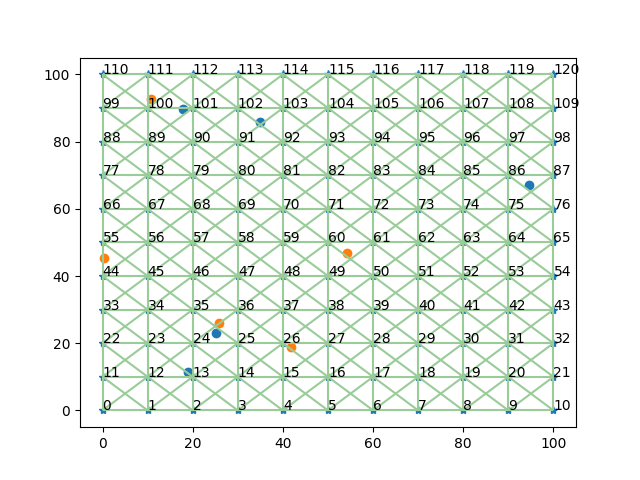

In [21]:
output_dir = Path('/home/rrg/desktop/david_configs')

road_map = generate_road_map(map_bounds, (11, 11))
# Generate independent landmark environment
timeouts = [3600]
map_bounds = (100.0, 100.0)
landmark_densities = [1e-3, 1e-2]
p_beacons = [0.1, 0.25, 0.5, 0.75, 1.0 - 1e-6]
for i, (p_beacon, landmark_density) in enumerate(itertools.product(p_beacons, landmark_densities)):
    for timeout in timeouts:
        rng = np.random.default_rng(i)
        environment = generate_independent_landmarks(map_bounds, p_beacon, landmark_density, rng=rng)
    
        experiment_dir = output_dir / Path(f'indep_p_beacon_{p_beacon:0.02f}_lm_density_{landmark_density:0.1E}_timeout_{timeout:2d}')
        
    
        eb.write_environment_to_file(experiment_dir, environment, write_road_map=False)
        with open(experiment_dir / 'road_map.pb', 'wb') as file_out:
            file_out.write(road_map.to_proto_string())
    
        with open(experiment_dir / 'experiment_config.pbtxt', 'w') as file_out:
            file_out.write(generate_experiment_config(f'indep_p_beacon_{p_beacon:0.02f}_lm_density_{landmark_density:0.1E}_timeout_{timeout:2d}', timeout, rng))
    
        num_landmarks = sum([x._pts_in_anchor.shape[1] for x in environment])
        print(num_landmarks, experiment_dir)
    
        fig = plt.figure()
        eb.draw_landmarks(plt.gca(), environment)
        plot_road_map(road_map)
        plt.savefig(experiment_dir / 'env.png')
        plt.close(fig)
    
    

# Generate spatially correlated landmark environments
cluster_densities = [5e-4, 1e-3]
cluster_size = (10, 10)
densities_within_cluster = [1e-1]
p_beacon_and_p_no_beacons = [
    (0.1, 0.1), (0.1, 0.5),
    (0.25, 0.1), (0.25, 0.5), 
    (0.5, 0.1), (0.5, 0.5),
    (0.75, 0.1), (0.75, 0.5),
    (1.0 - 1e-6, 0.1), (1.0 - 1e-6, 0.5),
]
for i, ((p_beacon, p_no_beacon), cluster_density, density_within_cluster) in enumerate(itertools.product(
        p_beacon_and_p_no_beacons,
        cluster_densities,
        densities_within_cluster
        )):
    for timeout in timeouts:
        rng = np.random.default_rng(i)
        environment = generate_spatially_correlated_landmarks(
            map_bounds, cluster_density, cluster_size, density_within_cluster, p_beacon, p_no_beacon, rng=rng)
    
        experiment_dir = output_dir / Path(f'spatial_clus_dens_{cluster_density:0.1E}_p_beacon_{p_beacon:0.02f}_p_no_beacon_{p_no_beacon:0.02f}_lm_density_{density_within_cluster:0.2E}_timeout_{timeout:2d}')
        num_landmarks = sum([x._pts_in_anchor.shape[1] for x in environment])
        print(num_landmarks, experiment_dir)
        
        eb.write_environment_to_file(experiment_dir, environment, write_road_map=False)
        with open(experiment_dir/ 'road_map.pb', 'wb') as file_out:
            file_out.write(road_map.to_proto_string())
    
        with open(experiment_dir / 'experiment_config.pbtxt', 'w') as file_out:
            file_out.write(generate_experiment_config(f'spatial_clus_dens_{cluster_density:0.1E}_p_beacon_{p_beacon:0.02f}_p_no_beacon_{p_no_beacon:0.02f}_lm_density_{density_within_cluster:0.2E}_timeout_{timeout:2d}', timeout, rng))
    
        fig = plt.figure()
        eb.draw_landmarks(plt.gca(), environment)
        plot_road_map(road_map)
        plt.savefig(experiment_dir / 'env.png')
        plt.close(fig)

# Generate semantically correlated landmark environments
num_classes = [2, 4, 8]
for i, (num_class, (p_beacon, p_no_beacons), landmark_density) in enumerate(itertools.product(
        num_classes,
        p_beacon_and_p_no_beacons,
        landmark_densities
        )):
    for timeout in timeouts:
        rng = np.random.default_rng(i)
        environment = generate_semantically_correlated_landmarks(
            map_bounds, num_class, p_beacon, p_no_beacon, landmark_density, rng=rng)
    
        experiment_dir = output_dir / Path(f'semantic_num_class_{num_class}_p_beacon_{p_beacon:0.2f}_p_no_beacon_{p_no_beacon:0.2f}_lm_density_{landmark_density:0.2E}_timeout_{timeout:2d}')
        eb.write_environment_to_file(experiment_dir, environment, write_road_map=False)
        num_landmarks = sum([x._pts_in_anchor.shape[1] for x in environment])
        print(num_landmarks, experiment_dir)
        with open(experiment_dir/ 'road_map.pb', 'wb') as file_out:
            file_out.write(road_map.to_proto_string())
    
        with open(experiment_dir / 'experiment_config.pbtxt', 'w') as file_out:
            file_out.write(generate_experiment_config(f'semantic_num_class_{num_class}_p_beacon_{p_beacon:0.2f}_p_no_beacon_{p_no_beacon:0.2f}_lm_density_{landmark_density:0.2E}_timeout_{timeout:2d}', timeout, rng))
    
        fig = plt.figure()
        eb.draw_landmarks(plt.gca(), environment)
        plot_road_map(road_map)
        plt.savefig(experiment_dir / 'env.png')
        plt.close(fig)

# Generate multiple mutual exclusion landmarks
for i, (num_class, landmark_density) in enumerate(itertools.product(
        num_classes,
        landmark_densities
        )):
    for timeout in timeouts:
        rng = np.random.default_rng(i)
        environment = generate_multiple_mutual_exclusion_landmarks(map_bounds, num_class, landmark_density, rng=rng)
        experiment_dir = output_dir / Path(f'mutex_num_class_{num_class}_lm_density_{landmark_density:0.2E}_timeout_{timeout:2d}')
        eb.write_environment_to_file(experiment_dir, environment, write_road_map=False)
        num_landmarks = sum([x._pts_in_anchor.shape[1] for x in environment])
        print(num_landmarks, experiment_dir)
        with open(experiment_dir/ 'road_map.pb', 'wb') as file_out:
            file_out.write(road_map.to_proto_string())
    
        with open(experiment_dir / 'experiment_config.pbtxt', 'w') as file_out:
            file_out.write(generate_experiment_config(f'mutex_num_class_{num_class}_lm_density_{landmark_density:0.2E}_timeout_{timeout:2d}', timeout, rng))
        
        fig = plt.figure()
        eb.draw_landmarks(plt.gca(), environment)
        plot_road_map(road_map)
        plt.savefig(experiment_dir / 'env.png')
        plt.close(fig)

In [20]:
def generate_experiment_config(name, timeout_s, rng):
    out = experiment_config.ExperimentConfig()
    out.name = name
    out.map_config_path = "world_map_config.pb"
    out.ekf_state_path = "mapped_landmarks.pb"
    out.road_map_path = "road_map.pb"
    out.evaluation_base_seed = rng.integers(1000000000)
    out.num_eval_trials = 1000
    out.start_goal_seed = rng.integers(1000000000)
    out.start_goal_connection_radius_m = 20.0
    out.num_trials = 20
    out.plan_timeout_s = timeout_s
    out.max_sensor_range_m = 4

    out.planner_configs.append(experiment_config.PlannerConfig(
        name = "Optimistic BRM",
        optimistic_brm_config = experiment_config.OptimisticBRMPlanner()
    ))

    out.planner_configs.append(experiment_config.PlannerConfig(
            name = f"Expected BRM 75 samples",
            expected_brm_config = experiment_config.ExpectedBRMPlanner(
                num_configuration_samples=75
            )
    ))

    return text_format.MessageToString(out)

In [21]:
output_dir = Path('/home/rrg/Desktop/david_configs')

road_map = generate_road_map(map_bounds, (11, 11))
timeouts = [60]
map_bounds = (100.0, 100.0)

# Generate spatially correlated landmark environments
cluster_densities = [1e-3]
cluster_size = (10, 10)
densities_within_cluster = [1e-1]
p_beacon_and_p_no_beacons = [ 
    (0.5, 0.1),
]
for i, ((p_beacon, p_no_beacon), cluster_density, density_within_cluster) in enumerate(itertools.product(
        p_beacon_and_p_no_beacons,
        cluster_densities,
        densities_within_cluster
        )):
    for timeout in timeouts:
        rng = np.random.default_rng(i)
        environment = generate_spatially_correlated_landmarks(
            map_bounds, cluster_density, cluster_size, density_within_cluster, p_beacon, p_no_beacon, rng=rng)
    
        experiment_dir = output_dir / Path(f'spatial_clus_dens_{cluster_density:0.1E}_p_beacon_{p_beacon:0.02f}_p_no_beacon_{p_no_beacon:0.02f}_lm_density_{density_within_cluster:0.2E}_timeout_{timeout:2d}')
        num_landmarks = sum([x._pts_in_anchor.shape[1] for x in environment])
        print(num_landmarks, experiment_dir)
        
        eb.write_environment_to_file(experiment_dir, environment, write_road_map=False)
        with open(experiment_dir/ 'road_map.pb', 'wb') as file_out:
            file_out.write(road_map.to_proto_string())
    
        with open(experiment_dir / 'experiment_config.pbtxt', 'w') as file_out:
            file_out.write(generate_experiment_config(f'spatial_clus_dens_{cluster_density:0.1E}_p_beacon_{p_beacon:0.02f}_p_no_beacon_{p_no_beacon:0.02f}_lm_density_{density_within_cluster:0.2E}_timeout_{timeout:2d}', timeout, rng))
    
        fig = plt.figure()
        eb.draw_landmarks(plt.gca(), environment)
        plot_road_map(road_map)
        plt.savefig(experiment_dir / 'env.png')
        plt.close(fig)


100 /home/rrg/Desktop/david_configs/spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_beacon_0.10_lm_density_1.00E-01_timeout_60


In [ ]:


p = Path('/tmp/experiment_configs/indep_p_beacon_1.00_lm_density_1.0E-02/world_map_config.pb')
wmc = WorldMapConfig()
wmc.ParseFromString(p.read_bytes())
print(wmc)

In [ ]:
f"{None:02d}"